# StyleGAN2-ADA

```
Step 1. Initial Setting and load pre-trained model
     1-a. import libraries
     1-b. clone the stylegan2-ada's git repository
     1-c. load pre-trained model that trained on afhqdog dataset
Step 2. generate sample fake-dog images
     2-a. a quick look at the model
     2-b. try submodels : g_mapping, g_synthesis
Step 3. image morphing
     3-a. create 2 random vector z and 2 intermediate latent space w
     3-b. generate 2 target fake-dog images
     3-c. control `z` and try image interpolation
Step 4. Project sample image to the latent space of pretrained network
     4-a. load a target image
     4-b. transform image file to numpy array
     4-c. load the pre-trained Generator
     4-d. Compute w stats
     4-e. Setup noise inputs
     4-f. Load VGG16 feature detector
     4-g. Extract features for target image
     4-h. Set optimizer and Initiate noise
     4-i. projection(training)
     4-j. Compare the target image with the generated image
Step 5. Change the characteristics of a new image



4. get age vecmtor (latent1 - latent2)
5. get another image
```

### Step 1. Initial Setting and load pre-trained model

**1-a. Import Libraries**

In [3]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

**1-b. clone the `stylegan2-ada`'s git repository**

In [4]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [5]:
%cd stylegan2-ada-pytorch

/kaggle/working/stylegan2-ada-pytorch


In [6]:
!ls

Dockerfile	 dataset_tool.py  generate.py	style_mixing.py
LICENSE.txt	 dnnlib		  legacy.py	torch_utils
README.md	 docker_run.sh	  metrics	train.py
calc_metrics.py  docs		  projector.py	training


In [7]:
!ls ../../input

afhq-dog-pretrained  animal-faces


**1-c. load pre-trained model that trained on `afhqdog` dataset**

In [8]:
with open('../../input/afhq-dog-pretrained/afhqdog.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

### Step 2. generate sample fake-dog images

**2-a. A quick look at the model**

The image generator `G` can be used like this :

In [9]:
z = torch.randn([1, G.z_dim]).cuda()
c = None
img = G(z,c)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [10]:
img.size()

torch.Size([1, 3, 512, 512])

In [11]:
torch.min(img)

tensor(-1.3052, device='cuda:0')

In [12]:
img.squeeze(0).size()

torch.Size([3, 512, 512])

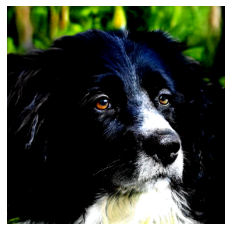

In [13]:
plt.imshow((img+0.5).cpu().squeeze(0).permute(1,2,0))
plt.axis('off')
plt.show();

**2-b. Try submodels : g_mapping, g_synthesis**

It is also possible to divide the G model into submodels.
- we will use this method in more detail, since we plan to adjust the latent vector later

In [14]:
g_mapping = G.mapping
g_synthesis = G.synthesis

Let's take a look at the model structure to see how it is implemented

In [15]:
g_mapping

MappingNetwork(
  (fc0): FullyConnectedLayer()
  (fc1): FullyConnectedLayer()
  (fc2): FullyConnectedLayer()
  (fc3): FullyConnectedLayer()
  (fc4): FullyConnectedLayer()
  (fc5): FullyConnectedLayer()
  (fc6): FullyConnectedLayer()
  (fc7): FullyConnectedLayer()
)

In [16]:
g_synthesis

SynthesisNetwork(
  (b4): SynthesisBlock(
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b8): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b16): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b32): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b64): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnec

make latent vector(space) `z` from random gaussian distribution

In [17]:
z = torch.randn([1, G.z_dim]).cuda()
z.size()

torch.Size([1, 512])

transforms `z` into the intermediate latent space `w` (disentangled space)

In [18]:
w = g_mapping(z, None)
w.size()

torch.Size([1, 16, 512])

Now pass `w`(transformed `z`) through the synthesis network to create the `fake image`

In [19]:
img = g_synthesis(w)
img = img.cpu()
img = img.squeeze(0)
img.size()

torch.Size([3, 512, 512])

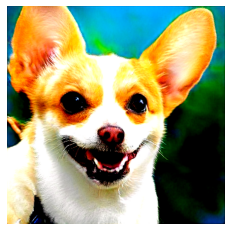

In [20]:
plt.imshow((img+0.3).permute(1,2,0))
plt.axis('off')
plt.show();

### Step 3. image morphing

Image Morphing | meaning
- (computing) The smooth transformation of one image into another


**3-a. create 2 random vector `z` and 2 intermediate latent space `w`**

In [64]:
z1 = torch.randn([1, G.z_dim]).cuda()
z2 = torch.randn([1, G.z_dim]).cuda()

w1 = g_mapping(z1, None)
w2 = g_mapping(z2, None)

**3-b. generate 2 target fake-dog images**

In [65]:
img1 = g_synthesis(w1)
img2 = g_synthesis(w2)

img1 = img1
img1 = img1.squeeze().permute(1,2,0)

img2 = img2
img2 = img2.squeeze().permute(1,2,0)

In [66]:
imgs = torch.cat([img1,img2], axis=1).cpu()
imgs.size()

torch.Size([512, 1024, 3])

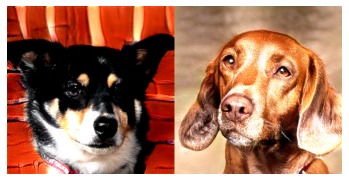

In [67]:
plt.imshow(imgs+0.85) # Increase the brightness by adding 0.85 to the pixel values
plt.axis('off')
plt.show()

**3-c. control `z` and try image interpolation**

In [69]:
img_group = []
lin = np.linspace(0, 1, 10)
print(*lin) # unpack the list

0.0 0.1111111111111111 0.2222222222222222 0.3333333333333333 0.4444444444444444 0.5555555555555556 0.6666666666666666 0.7777777777777777 0.8888888888888888 1.0


In [70]:
with torch.no_grad():
    for i in lin:
        w = ((1-i) * w1) + (i * w2) # style transfrom in for-loop : w1 --> w2
        result = g_synthesis(w)
        result = result.squeeze()
        img_group.append(result)

In [71]:
img_group = torch.cat(img_group).cpu()
img_group.size()

torch.Size([30, 512, 512])

This form is not an image. Let's change the shape to `NxCxHxW` and make it an image

In [72]:
img_group = img_group.view(10,3,512,512)
img_group.size()

torch.Size([10, 3, 512, 512])

And since we will represent the entire image with one image, let's represent 10(`N`) images as a grid.

In [73]:
grid_img = torchvision.utils.make_grid(img_group, nrow=5)
grid_img.size()

torch.Size([3, 1030, 2572])

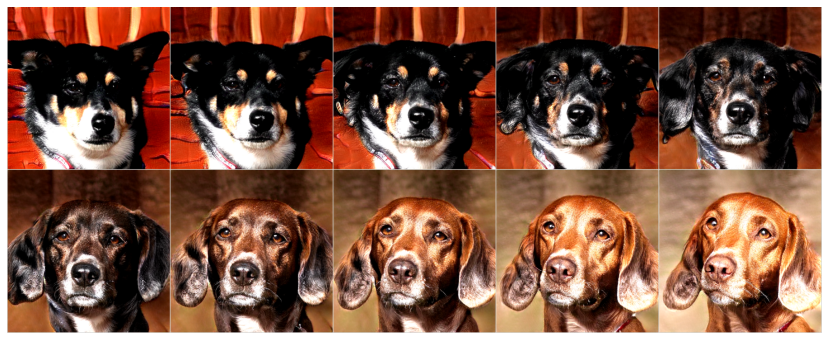

In [74]:
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1,2,0) +0.85) # The brightness value was also given by 0.85
plt.axis('off')
plt.show()

### Step 4. Project sample image to the latent space of pretrained network

**4-a. load a target image**

In [31]:
path = '../../input/animal-faces/afhq/train/dog/'

In [32]:
os.listdir(path)[:10]

['pixabay_dog_000933.jpg',
 'pixabay_dog_002339.jpg',
 'flickr_dog_000998.jpg',
 'flickr_dog_000236.jpg',
 'flickr_dog_000136.jpg',
 'flickr_dog_000614.jpg',
 'pixabay_dog_003169.jpg',
 'pixabay_dog_003317.jpg',
 'flickr_dog_000763.jpg',
 'pixabay_dog_002424.jpg']

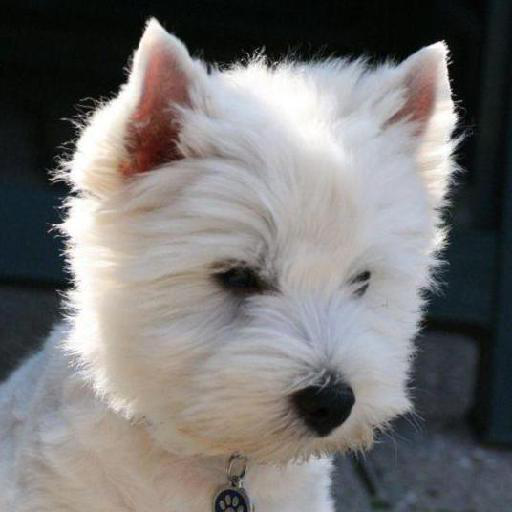

In [33]:
sample_flickr_dog_path = path+os.listdir(path)[2]
target_img = Image.open(sample_flickr_dog_path)
target_img

**4-b. transform image file to numpy array**

In [34]:
target_img.size

(512, 512)

In [35]:
target_uint8 = np.array(target_img, dtype=np.uint8)
target_uint8.shape

(512, 512, 3)

In [36]:
target_uint8[0]

array([[ 7,  9,  6],
       [ 7,  9,  6],
       [ 7,  9,  6],
       ...,
       [12, 22, 23],
       [12, 22, 23],
       [11, 21, 22]], dtype=uint8)

**4-c. load the pre-trained Generator**

In [37]:
device = torch.device('cuda')
G_eval = copy.deepcopy(G).eval().requires_grad_(False).to(device) # use g as the evaluation mode (do not track gradients)

**4-d. Compute `w` stats**

In [38]:
z_samples = np.random.randn(10000, G_eval.z_dim) # G_eval.z_dim == 512, (10000,512)
w_samples = G_eval.mapping(torch.from_numpy(z_samples).to(device), None)
w_samples.size()

torch.Size([10000, 16, 512])

In [39]:
w_samples = w_samples[:,:1,:].cpu().numpy().astype(np.float32)
w_samples

array([[[-0.27801913, -0.01979942, -0.17163044, ..., -0.07807784,
          0.42900476, -0.05428179]],

       [[-0.3051527 , -0.20043162, -0.00686904, ...,  0.30432925,
          0.7778967 ,  0.20334229]],

       [[-0.09631514, -0.14723678,  0.03708775, ...,  0.59618086,
          1.2782835 , -0.14736143]],

       ...,

       [[-0.14654855, -0.20909883, -0.13633583, ..., -0.06738123,
          0.87214196,  1.2596375 ]],

       [[ 0.74779594,  0.50638837, -0.12656619, ...,  0.20644708,
         -0.07212765,  0.80600756]],

       [[-0.17054725,  0.38892326,  0.01457484, ..., -0.11725987,
         -0.169078  , -0.06216115]]], dtype=float32)

In [40]:
w_samples.shape

(10000, 1, 512)

In [41]:
w_avg = np.mean(w_samples, axis=0, keepdims=True) 
w_avg.shape # mean of w_samples

(1, 1, 512)

In [42]:
w_std = (np.sum((w_samples - w_avg)**2)/10000)**0.5
w_std

9.031324307652781

**4-e. Setup noise inputs**

In [43]:
noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

**4-f. Load VGG16 feature detector**

In [75]:
import dnnlib

In [76]:
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)

**4-g. Extract features for target image**

In [77]:
target = torch.tensor(target_uint8.transpose([2,0,1]), device=device)
target.size()

torch.Size([3, 512, 512])

In [78]:
target = target.unsqueeze(0).to(device).to(torch.float32)
target.size()

torch.Size([1, 3, 512, 512])

In [79]:
target = F.interpolate(target, size=(256,256), mode='area') # Resize to pass through the vgg16 network.
target.size()

torch.Size([1, 3, 256, 256])

In [80]:
target_features = vgg16(target, resize_images=False, return_lpips=True)
target_features

tensor([[0.0000e+00, 0.0000e+00, 2.9206e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

In [81]:
target_features.size()

torch.Size([1, 7995392])

**4-h. Set optimizer and Initiate noise**

In [82]:
# suggested default hyper-parameter (official)
num_steps = 1000
initial_learning_rate = 0.1
# ========================================= #

w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

# Init noise.
for buf in noise_bufs.values():
    buf[:] = torch.randn_like(buf)
    buf.requires_grad = True

**4-i. projection(training)**

- reducing the loss to create an image that mimics the target well.
- Finding the input vector(w) while generating a well-replicated image.

In [85]:
# suggested default hyper-parameter (official)
num_steps = 1000
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_noise_factor = 0.05
noise_ramp_length = 0.75
regularize_noise_weight = 1e5
# ========================================= #

for step in tqdm(range(num_steps)):
    # Learning rate schedule.
    t = step / num_steps
    w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    # Synthesize image from opt_w
    w_noise = torch.randn_like(w_opt) * w_noise_scale
    ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
    synth_images = G.synthesis(ws, noise_mode='const')
    
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_images = (synth_images + 1) * (255/2)
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')
        
    # Features for synth images.
    synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
    dist = (target_features - synth_features).square().sum() # Calculate the difference between two feature maps (target vs synth) generated through vgg. 
                                                             # This is the point of projection.
    # Noise regularization.
    reg_loss = 0.0
    for v in noise_bufs.values():
        noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
        while True:
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
            if noise.shape[2] <= 8:
                break
            noise = F.avg_pool2d(noise, kernel_size=2)
    loss = dist + reg_loss * regularize_noise_weight
    
    # Step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
    
    # Save projected W for each optimization step.
    w_out[step] = w_opt.detach()[0]

    # Normalize noise.
    with torch.no_grad():
        for buf in noise_bufs.values():
            buf -= buf.mean()
            buf *= buf.square().mean().rsqrt()

  0%|          | 0/1000 [00:00<?, ?it/s]

step    1/1000: dist 0.40 loss 9.64 
step    2/1000: dist 0.41 loss 9.64 
step    3/1000: dist 0.43 loss 8.09 
step    4/1000: dist 0.44 loss 4.45 
step    5/1000: dist 0.43 loss 1.73 
step    6/1000: dist 0.41 loss 4.62 
step    7/1000: dist 0.44 loss 11.67
step    8/1000: dist 0.42 loss 12.68
step    9/1000: dist 0.41 loss 4.80 
step   10/1000: dist 0.43 loss 1.19 
step   11/1000: dist 0.41 loss 8.47 
step   12/1000: dist 0.42 loss 10.19
step   13/1000: dist 0.39 loss 2.13 
step   14/1000: dist 0.40 loss 3.77 
step   15/1000: dist 0.42 loss 9.47 
step   16/1000: dist 0.40 loss 3.43 
step   17/1000: dist 0.41 loss 3.36 
step   18/1000: dist 0.40 loss 8.06 
step   19/1000: dist 0.42 loss 2.76 
step   20/1000: dist 0.45 loss 4.38 
step   21/1000: dist 0.43 loss 5.95 
step   22/1000: dist 0.40 loss 1.59 
step   23/1000: dist 0.41 loss 5.33 
step   24/1000: dist 0.44 loss 2.31 
step   25/1000: dist 0.43 loss 3.19 
step   26/1000: dist 0.39 loss 3.37 
step   27/1000: dist 0.41 loss 1.86 
s

In [87]:
w_out.size()

torch.Size([1000, 1, 512])

In [88]:
w_out.repeat([1, G.mapping.num_ws, 1]).size()

torch.Size([1000, 16, 512])

In [92]:
projected_w_steps = w_out.repeat([1, G.mapping.num_ws, 1])
projected_w = projected_w_steps[-1]
print(projected_w.size())
print(projected_w)

torch.Size([16, 512])
tensor([[0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897],
        [0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897],
        [0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897],
        ...,
        [0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897],
        [0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897],
        [0.8992, 0.9903, 0.1668,  ..., 3.0016, 0.3878, 1.0897]],
       device='cuda:0')


In [93]:
np_w = projected_w.cpu().numpy()
np.save('./projected_w', np_w)

**4-j. Compare the target image with the generated image**

In [94]:
synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

In [98]:
synth_image.shape

(512, 512, 3)

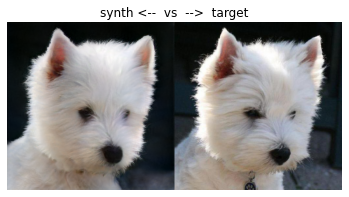

In [126]:
plt.imshow(np.concatenate((synth_image, target_uint8), axis=1))
plt.axis('off')
plt.title('synth <--  vs  -->  target')
plt.show()